In [1]:
from models import Discriminator, UNet, Generator
from datasets import ImageDataset,tophat
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch
import torchvision
from skimage import io, morphology
import matplotlib.pyplot as plt
import numpy as np
from models import UNet,Generator
from PIL import Image,ImageOps
from tqdm import tqdm
import random
import cv2
from utils import fusion_predict, make_mask, merge_ckpts, denorm
%load_ext autoreload
%autoreload 2

### 多角度融合

(<matplotlib.axes._subplots.AxesSubplot at 0x7f663c959d50>,
 <matplotlib.image.AxesImage at 0x7f663c9a1810>)

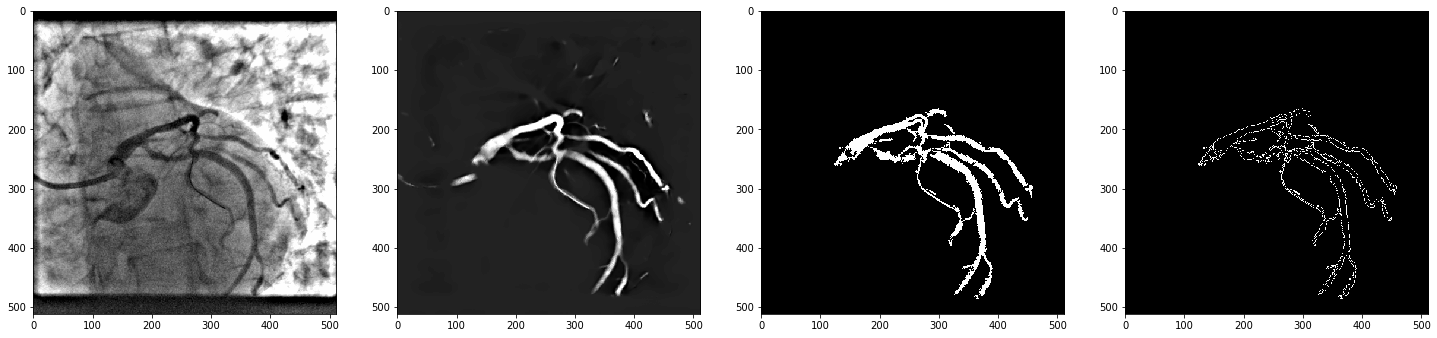

In [29]:
sz = 512
tfmc = T.Compose([
    T.Resize(sz),
    T.Lambda(lambda img: tophat(img,50)),
#     T.CenterCrop(400),
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

ds = ImageDataset('datasets/cycledsa_v45/', size=sz, unaligned=False, mode='test', transform=tfmc)

netG_B2A = UNet(1, 1, 32, bilinear=True)
netG_B2A = torch.nn.DataParallel(netG_B2A)
ckpts = [
#      'mlruns/3/717b1625375147ba9e7f68bf47be9296/last.ckpt', # sz512
#          'mlruns/3/887fe32048a7458aa201775b6b022128/010.ckpt', # randtophat_sz512 7-10ep加强gamma好像可以
#         'mlruns/3/887fe32048a7458aa201775b6b022128/015.ckpt', # randtophat_sz512 7-10ep加强gamma好像可以
#         'mlruns/3/887fe32048a7458aa201775b6b022128/019.ckpt', # randtophat_sz512 7-10ep加强gamma好像可以
#             'mlruns/4/1b739448a0194e1e92f159d4bbc5e965/039.ckpt', # v46
#         'mlruns/4/1b739448a0194e1e92f159d4bbc5e965/035.ckpt', # v46-tophat
        'mlruns/4/d8ec4f94fb6c41898ccf20162c5a0ba3/last.ckpt', # v46-ep60




    

]

# # resnet
# netG_B2A = Generator(1, 1)
# netG_B2A = torch.nn.DataParallel(netG_B2A)
# ckpts = [
#     'mlruns/0/bed13f38d5e148baac9563841815eabf/048.ckpt', # bs4_res 其他挺，但103不好
#     'mlruns/0/1d40d2833f82492c90aecdb4343bdb1a/048.ckpt', # bs4_res_noRoate sota3
#     'mlruns/0/78e1e67ae33b4c8aa95ba095f11f939f/038.ckpt', # bs4_res_tophat_noRotate
#     'mlruns/0/c03f607a02424ac98a9a612bcdfb83e4/049.ckpt', # bs4_res_tophat ★★★ 背景识别更精准
#      'mlruns/3/cc806258307844ecaa4c430acb757616/018.ckpt', # res_sz512_ep20
# ]

idx = 53
ids =[13,14,33,9,10,99,108,45] # 63 88 103 200有病变 300-302 413高度混杂 414狭窄 502低对比度 504残缺 131低对比度 100大伪影
# good 65 66 68 44 34
# 35 27 41 107 112中断
x = ds[idx]['B']
B,out = fusion_predict(netG_B2A, ckpts, x, multiangle=False, denoise=3, size=sz, cutoff=1, pad=0, padding_mode='reflect')
mask, skel = make_mask(out,remove_size=1000, return_skel=False,local_kernel=5)

out = T.functional.adjust_gamma(out,1.5)

plt.figure(figsize=(25,25))
plt.subplot(141),plt.imshow(B)
plt.subplot(142),plt.imshow(out)
plt.subplot(143),plt.imshow(mask,cmap='gray')
plt.subplot(144),plt.imshow(skel)

# plt.show()

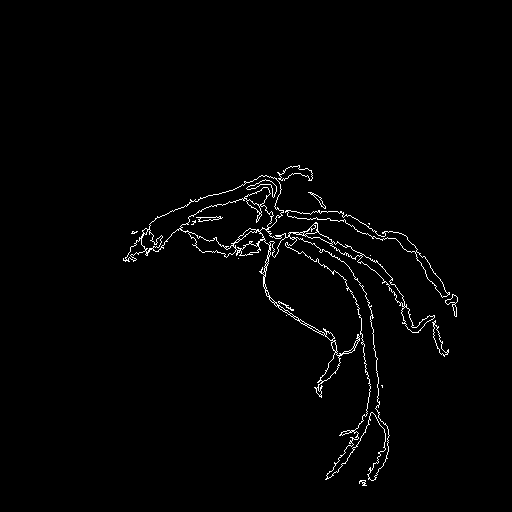

In [30]:
skel

### CKPT Merge

In [59]:
ckpts = []
ckpts.append(torch.load('mlruns/0/e92b15a61d2c4813aa81d879f22422e7/099.ckpt', map_location='cpu')['netG_B2A'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/140.ckpt', map_location='cpu')['netE'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/160.ckpt', map_location='cpu')['netE'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/199.ckpt', map_location='cpu')['netE'])


ckptm = merge_ckpts(ckpts)

x = ds[idx]['B']
B,out = fusion_predict(netG_B2A, [ckptm], x, pad=50, multiangle=True, denoise=5, size=sz)
mask, skel = make_mask(out,remove_size=1000, return_skel=True)
out = T.functional.adjust_gamma(out,1.5)



plt.figure(figsize=(25,25))
plt.subplot(141),plt.imshow(B)
plt.subplot(142),plt.imshow(out)
plt.subplot(143),plt.imshow(mask,cmap='gray')
plt.subplot(144),plt.imshow(skel)

plt.show()

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "model.1.weight", "model.1.bias", "model.4.weight", "model.4.bias", "model.7.weight", "model.7.bias", "model.10.conv_block.1.weight", "model.10.conv_block.1.bias", "model.10.conv_block.5.weight", "model.10.conv_block.5.bias", "model.11.conv_block.1.weight", "model.11.conv_block.1.bias", "model.11.conv_block.5.weight", "model.11.conv_block.5.bias", "model.12.conv_block.1.weight", "model.12.conv_block.1.bias", "model.12.conv_block.5.weight", "model.12.conv_block.5.bias", "model.13.conv_block.1.weight", "model.13.conv_block.1.bias", "model.13.conv_block.5.weight", "model.13.conv_block.5.bias", "model.14.conv_block.1.weight", "model.14.conv_block.1.bias", "model.14.conv_block.5.weight", "model.14.conv_block.5.bias", "model.15.conv_block.1.weight", "model.15.conv_block.1.bias", "model.15.conv_block.5.weight", "model.15.conv_block.5.bias", "model.16.conv_block.1.weight", "model.16.conv_block.1.bias", "model.16.conv_block.5.weight", "model.16.conv_block.5.bias", "model.17.conv_block.1.weight", "model.17.conv_block.1.bias", "model.17.conv_block.5.weight", "model.17.conv_block.5.bias", "model.18.conv_block.1.weight", "model.18.conv_block.1.bias", "model.18.conv_block.5.weight", "model.18.conv_block.5.bias", "model.19.weight", "model.19.bias", "model.22.weight", "model.22.bias", "model.26.weight", "model.26.bias". 
	Unexpected key(s) in state_dict: "inc.double_conv.0.weight", "inc.double_conv.0.bias", "inc.double_conv.3.weight", "inc.double_conv.3.bias", "down1.maxpool_conv.1.double_conv.0.weight", "down1.maxpool_conv.1.double_conv.0.bias", "down1.maxpool_conv.1.double_conv.3.weight", "down1.maxpool_conv.1.double_conv.3.bias", "down2.maxpool_conv.1.double_conv.0.weight", "down2.maxpool_conv.1.double_conv.0.bias", "down2.maxpool_conv.1.double_conv.3.weight", "down2.maxpool_conv.1.double_conv.3.bias", "down3.maxpool_conv.1.double_conv.0.weight", "down3.maxpool_conv.1.double_conv.0.bias", "down3.maxpool_conv.1.double_conv.3.weight", "down3.maxpool_conv.1.double_conv.3.bias", "down4.maxpool_conv.1.double_conv.0.weight", "down4.maxpool_conv.1.double_conv.0.bias", "down4.maxpool_conv.1.double_conv.3.weight", "down4.maxpool_conv.1.double_conv.3.bias", "up1.conv.double_conv.0.weight", "up1.conv.double_conv.0.bias", "up1.conv.double_conv.3.weight", "up1.conv.double_conv.3.bias", "up2.conv.double_conv.0.weight", "up2.conv.double_conv.0.bias", "up2.conv.double_conv.3.weight", "up2.conv.double_conv.3.bias", "up3.conv.double_conv.0.weight", "up3.conv.double_conv.0.bias", "up3.conv.double_conv.3.weight", "up3.conv.double_conv.3.bias", "up4.conv.double_conv.0.weight", "up4.conv.double_conv.0.bias", "up4.conv.double_conv.3.weight", "up4.conv.double_conv.3.bias", "outc.conv.weight", "outc.conv.bias". 